# 1. **Data Collection**

## 1.1. Dependecies and Directory

In [ ]:
import pandas as pd
import wikipedia as wp
import yfinance as yf
import numpy as np
from ta.momentum import rsi
from ta.trend import macd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

In [13]:
os.makedirs("data", exist_ok=True)

## 1.2. Stock Market Data

The first step in our pipeline is to fetch a comprehensive list of companies within the S&P 100 index from Wikipedia. This data includes:

- Company Name
- Ticker (Symbols)
- Sector

In [33]:
url = wp.page("S&P 100").html().encode("UTF-8")

stocks=pd.read_html(url)[2].set_index("Symbol")
stocks.index=stocks.index.rename("Ticker")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Ticker,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


In [15]:
stocks.to_csv("data/stocks.csv")

## 1.3. Financial Insights: Fundamental Extraction

Financial fundamentals provide a snapshot of each company’s financial health. Using `yfinance`, we extract key metrics such as:



- Market Capitalization (`marketCap`): The total market value of a company's outstanding shares, representing its size in the stock market.
  
- Trailing Price-to-Earnings Ratio (`trailingPE`): Valuation ratio based on the last 12 months of earnings, used to assess whether a stock is over or undervalued.
  
- Forward Price-to-Earnings Ratio (`forwardPE`): Valuation ratio based on projected earnings; helps predict future stock valuation.
  
- Price-to-Book Ratio (`priceToBook`): Ratio of a stock's market price to its book value; measures how the market values the company's assets.
  
- Trailing Earnings Per Share (`trailingEps`): Net income divided by outstanding shares over the past 12 months; measures profitability per share.
  
- Book Value per Share (`bookValue`): Total assets minus liabilities, divided by outstanding shares, indicates the company's net assets value.
  
- Dividend Payout Ratio (`payoutRatio`): Percentage of earnings paid as dividends; evaluates dividend distribution sustainability.
  
- Beta (`beta`): Measures stock volatility relative to the market (e.g. beta > 1 is more volatile than the market).
  
- Five-Year Average Dividend Yield (`fiveYearAvgDividendYield`): Average dividend yield over the last five years; indicates cash return from dividends.
  
- 52-Week Price Change (`52WeekChange`): Percentage price change over the last year; indicates recent stock performance.
  
- Average Trading Volume (`averageVolume`): Average daily number of shares traded; reflects stock liquidity.
  
- Enterprise Value-to-Revenue Ratio (`enterpriseToRevenue`): Ratio of enterprise value to revenue; measures efficiency in generating revenue relative to valuation.
  
- Profit Marging (`profitMargins`): Percentage of revenue retained as net profit; indicates profitability efficiency.

In [16]:
fundamentals =[yf.Ticker(stock).info for stock in stocks.index]
fundamentals= pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index=fundamentals.index.rename("Ticker")
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Ticker,,,,,,,,,,,,,,
AAPL,3750683475968,40.810856,29.851196,65.869390,6.08,8.31,3.767,0.1612,1.240,0.62,0.255049,47707123,9.730,0.23971
ABBV,308135690240,60.197914,14.249549,50.796950,2.88,12.13,3.413,2.1359,0.613,4.13,0.124318,5917071,6.671,0.09223
ABT,197970542592,34.567074,21.973421,4.941597,3.28,5.16,22.944,0.6565,0.722,1.65,0.061236,5050076,4.953,0.13992
ACN,226400600064,31.325764,25.582594,7.928031,11.45,14.07,45.242,0.4510,1.245,1.36,0.046579,2482541,3.453,0.11194
ADBE,237519601664,37.738250,20.203550,14.247820,12.34,20.55,32.685,0.0000,1.299,0.12,-0.188223,3156392,11.488,0.25588


The data is normalized to standardize variables, ensuring a consistent scale for accurate comparisons across companies.

In [17]:
normalized_fundamentals=(fundamentals-fundamentals.mean())/fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Ticker,,,,,,,,,,,,,,
AAPL,4.946852,0.008455,0.104287,2.392636,-0.218981,-0.209777,-0.100823,-0.212191,0.713554,-1.017199,0.132918,1.285577,0.884289,0.653144
ABBV,-0.116199,0.198712,-0.235871,1.731949,-0.414020,-0.033784,-0.100832,0.372491,-0.923289,1.050662,-0.275913,-0.262392,0.299419,-0.484589
ABT,-0.278222,-0.052820,-0.067470,-0.278077,-0.389640,-0.354902,-0.100385,-0.065539,-0.638734,-0.410391,-0.473189,-0.294507,-0.029056,-0.116685
ACN,-0.236409,-0.084629,0.011220,-0.147170,0.108320,0.055594,-0.099875,-0.126385,0.726606,-0.581240,-0.519027,-0.389613,-0.315851,-0.332536
ADBE,-0.220056,-0.021699,-0.106058,0.129852,0.162565,0.354138,-0.100162,-0.259920,0.867579,-1.311766,-1.253316,-0.364652,1.220413,0.777887


**Data NA values review**

In [18]:
print(fundamentals.isna().sum())

marketCap                   0
trailingPE                  0
forwardPE                   0
priceToBook                 0
trailingEps                 0
forwardEps                  0
bookValue                   0
payoutRatio                 0
beta                        0
fiveYearAvgDividendYield    0
52WeekChange                0
averageVolume               0
enterpriseToRevenue         0
profitMargins               0
dtype: int64


In [19]:
normalized_fundamentals.to_csv("../data/fundamentals.csv")

## 1.4. Market Movements: Historical Data Analysis

Using `yfinance`, we retrieve stock prices and trading volumes for the past five years. Additional we calculate key metrics to analyze individual stock performance and sector-level behavior:

- Normalized Closing Price (`NormClose`): Standardized stock prices to compare stocks across different scales.
  
- Daily Log Returns (`DailyLogReturn`): Daily percentage price changes.

- Aggregated Log Returns (`ALR1M`, `ALR3M`): Monthly and quarterly returns to assess medium-term stock performance.

- Volatility (`Volatility`): Rolling 1-month standard deviation of log returns to measure risk.

- Technical Indicator (`ta`): 
  - RSI (Relative Strength Index): Identifies overbought or oversold conditions.
  - MACD (Moving Average Convergence Divergence): Tracks momentum shifts and potential trend reversals.

- Volumen (`Volume`): Reflects market activity and liquidity.

- High-Low Range (`HighLowRange`): Captures intraday price fluctuations.

- Rolling Covariance Matrices (`rolling_cov_matrices`): 200-day rolling covariance of log returns to analyze inter-stock dependencies.

In [46]:
values=[ yf.Ticker(stock).history(period="5y",actions=False) for stock in stocks.index]

daily_returns={}

for idx, stock_values in enumerate(values):
    #Log returns
    stock_values["NormClose"]=(stock_values["Close"] - stock_values["Close"].mean())/stock_values["Close"].std()
    stock_values["DailyLogReturn"]=np.log(1+stock_values["Close"].pct_change())
    stock_values["ALR1M"]=stock_values["DailyLogReturn"].rolling(window=21).sum()*21
    stock_values["ALR3M"]=stock_values["DailyLogReturn"].rolling(window=63).sum()*21
    stock_values["Volatility"]=stock_values["DailyLogReturn"].rolling(window=21).std() 
    stock_values["RSI"]=rsi(stock_values["Close"])/100
    stock_values["MACD"]=macd(stock_values["Close"])
    stock_values["Volume"]=stock_values["Volume"]
    stock_values["HighLowRange"]=stock_values["High"]-stock_values["Low"]
    
    daily_returns[stocks.index[idx]]=stock_values["DailyLogReturn"]
    stock_values.drop(columns=["Open","High","Low"],inplace=True)

values=pd.concat(values,keys=stocks.index).dropna()
returns_df=pd.DataFrame(daily_returns)
rolling_cov_matrices=returns_df.rolling(window=200).cov()

print(values.head(n=5))

                                      Close     Volume  NormClose  \
Ticker Date                                                         
AAPL   2020-03-18 00:00:00-04:00  59.927452  300233600  -2.175187   
       2020-03-19 00:00:00-04:00  59.468281  271857200  -2.186186   
       2020-03-20 00:00:00-04:00  55.692909  401693200  -2.276623   
       2020-03-23 00:00:00-04:00  54.509758  336752800  -2.304964   
       2020-03-24 00:00:00-04:00  59.978474  287531200  -2.173964   

                                  DailyLogReturn     ALR1M     ALR3M  \
Ticker Date                                                            
AAPL   2020-03-18 00:00:00-04:00       -0.024784 -5.399936 -2.601216   
       2020-03-19 00:00:00-04:00       -0.007692 -5.863415 -2.803981   
       2020-03-20 00:00:00-04:00       -0.065590 -7.024256 -4.131134   
       2020-03-23 00:00:00-04:00       -0.021473 -6.994397 -4.603076   
       2020-03-24 00:00:00-04:00        0.095606 -3.964687 -2.551809   

           

**Data NA values review**

In [21]:
print(values.isna().sum())

Close             0
Volume            0
NormClose         0
DailyLogReturn    0
ALR1M             0
ALR3M             0
Volatility        0
RSI               0
MACD              0
HighLowRange      0
dtype: int64


In [24]:
values.to_csv("../data/values.csv")
rolling_cov_matrices.to_csv("../data/rolling_cov_matrices.csv")
returns_df.to_csv("../data/daily_returns.csv")

## 1.5. Sector Aggregation

We aggregate stock-level data to sector level to gain a broader understanding of market dynamics and prepare for subsequent analysis:

- **Average Sector Returns**: We calculate the average daily log returns for each sector, summarizing overall sector performance and identifying high-or-low performing sectors.

- **Sector Volatility**: We compute the average volatility per sector to highlight the risk profiles of different market segments.

- **Sector Returns Over Time**:  By aggregating stock returns, we track the daily performance of sectors over time, enabling trend analysis and comparative studies.

- **Rolling Sector Correlations**: We derive rolling correlations between sector returns to explore how sector interdependencies evolve.

In [ ]:
sector_means = (
    values.reset_index()
    .groupby("Ticker")["DailyLogReturn"]
    .mean()
    .reset_index()
    .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker") 
    .groupby("Sector")["DailyLogReturn"] 
    .mean()
)

sector_volatility = (
    values.reset_index()
    .groupby("Ticker")["Volatility"]  
    .mean()
    .reset_index()
    .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker") 
    .groupby("Sector")["Volatility"] 
    .mean()
    .sort_values(ascending=False) 
)

sector_returns = (
    values.reset_index()
    .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker")
    .groupby(["Sector", "Date"])["DailyLogReturn"]
    .mean()
    .unstack(level=0)  
)

rolling_sector_corr = sector_returns.rolling(window=200).corr()

In [38]:
sector_means.to_csv("data/sector_means.csv")
sector_volatility.to_csv("data/sector_volatility.csv")
sector_returns.to_csv("data/sector_returns.csv")
rolling_sector_corr.to_csv("data/rolling_sector_corr.csv")

## 1.6. Visualization

#### **Distribution of Daily Log Returns**

The main purpose of this graph is to understand the variability and spread of daily stock returns.

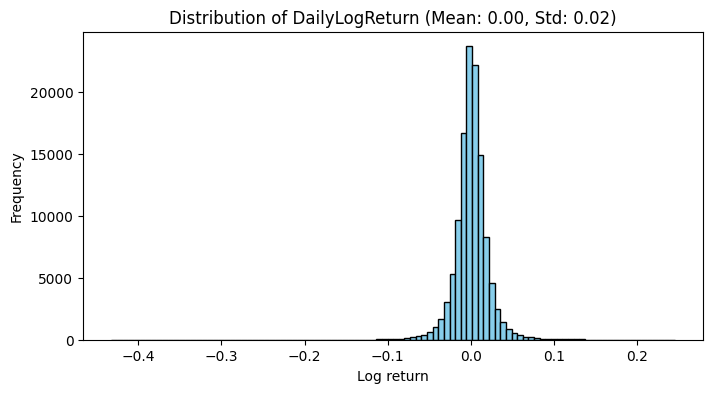

In [32]:
plt.figure(figsize=(8, 4))
column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

The distribution shows a narrow spread around 0 (standard deviation ~0.02), indicating that most daily price changes are small. The symmetry of the distribution suggest a balanced pattern of positive and negative returns, which is typical in financial markets.

#### **Distribution of Aggregated Log Returns**

The main purpose of this graph is to analyze return patterns over monthly and quarterly horizons. This allows us to observe medium-term trends and variability, which are crucial for understanding market dynamics over longer periods.

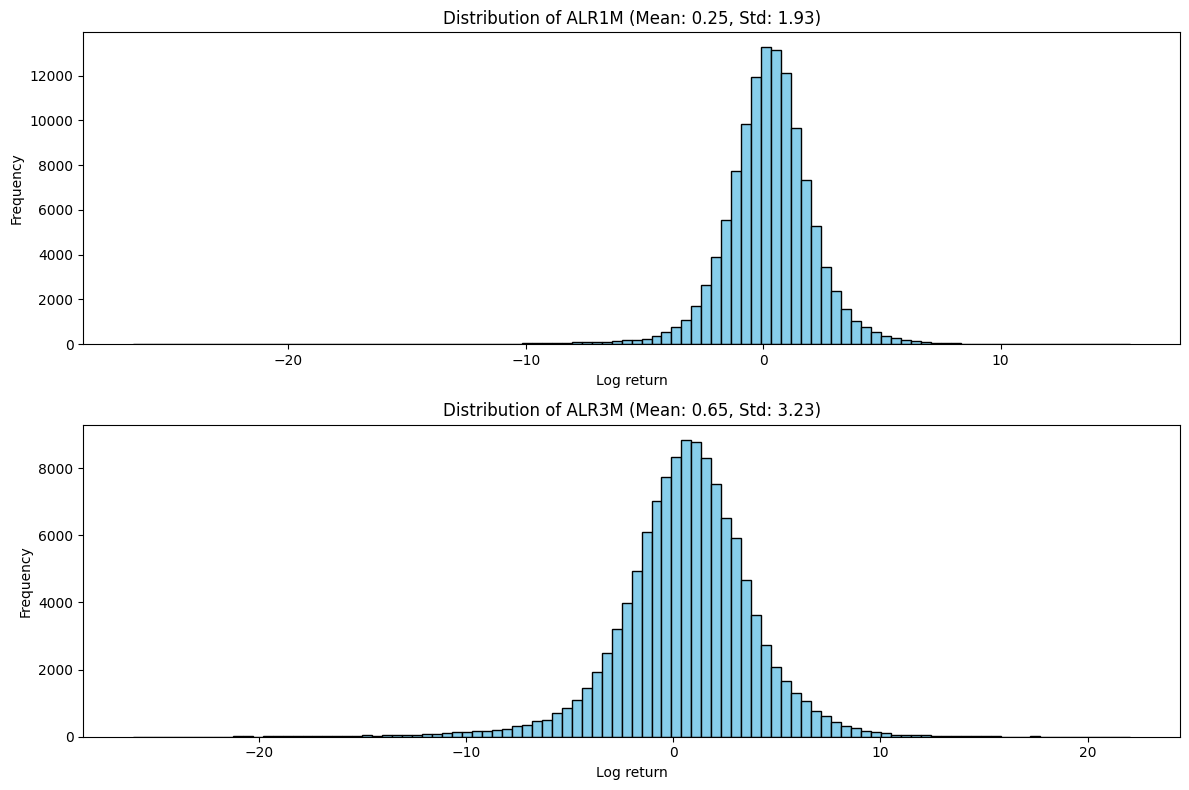

In [26]:
fig, axs = plt.subplots(2, figsize=(12, 8)) 
for idx, column in enumerate(["ALR1M", "ALR3M"]):
    ax = axs[idx]  
    ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
    ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
    ax.set_xlabel("Log return")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

**ALR1M (Monthly Returns)**: The distribution has a mean of 0.25, indicating a slight positive bias, with a standard deviation of 1.93, reflecting moderate variability over one-month periods. 

**ALR3M (Quarterly Returns)**: The mean of 0.65 shows a larger positive bias, while the standard deviation of 3.23 indicates higher variability, as expected for loner time horizons.

In conclusion, longer time periods (ALR3M vs. ALR1M) show higher average returns but also greater variability, reflecting the increased risk and reward associated with extended investment horizons.

#### **Sector-Wide Cumulative Returns**

The main purpose of this graph is to visualize cumulative performance trends for each sector over time. It provides an overview of sector-level market dynamics and helps identify outperforming or underperforming sectors.

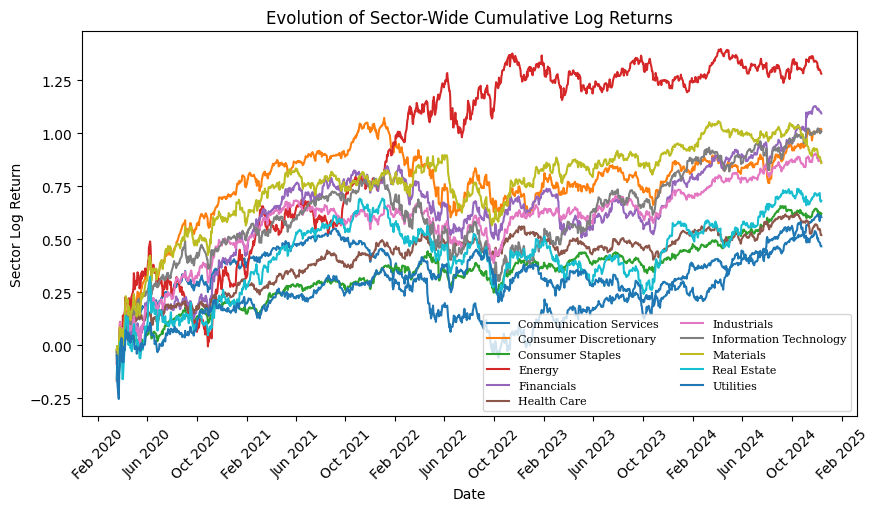

In [39]:
plt.figure(figsize=(10, 5))

for sector in sector_means.index:
    sector_values = (
        values.reset_index()
        .merge(stocks.reset_index()[["Ticker", "Sector"]], on="Ticker")
        .query(f"Sector == '{sector}'")
    )
    
    cumulative_returns = (
        sector_values.groupby("Date")["DailyLogReturn"].mean().cumsum()
    )
    
    plt.plot(cumulative_returns.index, cumulative_returns, label=sector)

plt.title("Evolution of Sector-Wide Cumulative Log Returns")
plt.xlabel("Date")
plt.gca().tick_params(axis="x", rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.ylabel("Sector Log Return")
plt.legend(ncol=2, loc="lower right", prop={"size": 8, "family": "serif"})
plt.show()

**Diverging Trends**: Some sectors (e.g. Technology) exhibit sustained growth over time, while others (e.g. Utilities) show more modest gains, reflecting the varying growth potential and market dynamics.

**Volatility of the Market**: The early 2020 dip shows COVID-19’s market-wide impact, with Technology rebounding the fastest, while Energy faced prolonged recovery linked to oil price volatility.

**Strategic Implications**: High-growth sectors like Technology suit long-term investors, while defensive sectors like Utilities offer stability during market downturns.

#### **Average Volatility by Sector**

The main purpose of this graph is to compare the risk profiles of different sectors. By visualizing average volatility, we can identify which sectors exhibit higher instability and potential investment risks

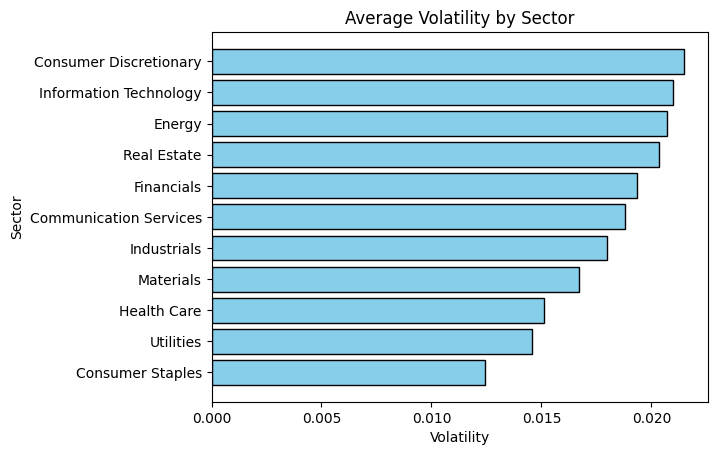

In [ ]:
plt.barh(sector_volatility.index, sector_volatility.values, color="skyblue", edgecolor="black")
plt.title("Average Volatility by Sector")
plt.xlabel("Volatility")
plt.ylabel("Sector")
plt.gca().invert_yaxis()  
plt.show()

**High Volatility Sectors**: Consumer Discretionary and Technology exhibit the hightest volatility, reflecting sensitivity to market trends and economic shifts.

**Low Volatility Sectors**: Consumer Staples and Utilities show the lowest volatility, aligning with their reputation as defensive sectors during economic uncertainty.

#### **Correlation Heatmap of Stock Returns**

The main purpose of this graph is to reveal relationships and dependencies among stock returns. 

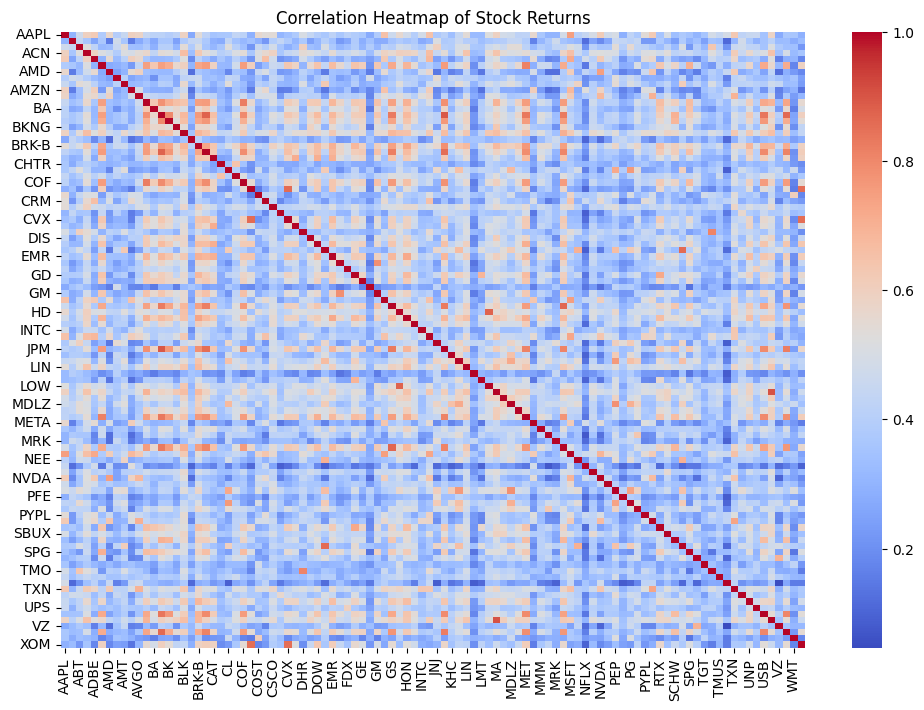

In [29]:
correlation_matrix = returns_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Stock Returns")
plt.show()